In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
#read data
Changping_data_raw=pd.read_csv('PRSA_Data_Changping_20130301-20170228.csv')
Changping_data = np.array(Changping_data_raw)

In [3]:
# Training set
data_pm25 = Changping_data[:,11:16] #input data
lable_pm25 = Changping_data[:,8] #output label

data_pm25 = np.array(data_pm25)
lable_pm25 = np.array(lable_pm25)

mean = data_pm25.mean(axis=0, dtype=float)
std = data_pm25.std(axis=0, dtype=float)

In [4]:
train_data = data_pm25[0:int(len(data_pm25)*0.8)]
train_label = lable_pm25[0:int(len(data_pm25)*0.8)]
test_data = data_pm25[int(len(data_pm25)*0.8):int(len(data_pm25))]
test_label = lable_pm25[int(len(data_pm25)*0.8):int(len(data_pm25))]

train_data = np.array(train_data, dtype= np.float32)
train_label = np.array(train_label, dtype= np.float32)
test_data = np.array(test_data, dtype= np.float32)
test_label = np.array(test_label, dtype= np.float32)

train_data = (train_data - mean) / std # (train_data - min) / (max-min) 
test_data = (test_data - mean) / std

print(train_data.shape,train_label.shape,test_data.shape,test_label.shape)

(1100, 5) (1100,) (275, 5) (275,)


In [5]:
n_filters  = 32  # number of filters
n_neurons  = 32  # number of neurons in the Dense layer
activation     = 'relu' # activation function
kernel_size    = 4
learning_rate  = 0.001
minibatch_size = 64
num_epochs     = 50

In [6]:
model = Sequential()

model.add(Dense(n_filters*12*18, input_shape=(train_data.shape[1],), activation=activation)) # shape: (6912,1)
model.add(Reshape((12,18,n_filters))) # shape: (12,18,32)

# Upsample to 24x36
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (24,36,32)

# Upsample to 48x72
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (48,72,32)

# Upsample to 96x144
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (96,144,32)

model.add(Conv2DTranspose(filters=1, kernel_size=kernel_size, activation="linear", padding="same")) # shape: (96,144,1)


model.summary()
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6912)              41472     
                                                                 
 reshape (Reshape)           (None, 12, 18, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 24, 36, 32)       16416     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 48, 72, 32)       16416     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 96, 144, 32)      16416     
 ranspose)                                                       
                                                        

2022-12-22 21:01:14.917312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(train_data, train_label, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/50
14/14 [==============================] - 10s 653ms/step - loss: 4384.4370 - val_loss: 3603.2183
Epoch 2/50
14/14 [==============================] - 10s 742ms/step - loss: 3784.6655 - val_loss: 2180.2603
Epoch 3/50
14/14 [==============================] - 9s 616ms/step - loss: 2145.2646 - val_loss: 1417.2332
Epoch 4/50
14/14 [==============================] - 8s 601ms/step - loss: 1782.6176 - val_loss: 1354.1896
Epoch 5/50
14/14 [==============================] - 9s 622ms/step - loss: 1693.5332 - val_loss: 1344.1013
Epoch 6/50
14/14 [==============================] - 8s 604ms/step - loss: 1661.5378 - val_loss: 1366.8386
Epoch 7/50
14/14 [==============================] - 8s 598ms/step - loss: 1627.4733 - val_loss: 1347.0314
Epoch 8/50
14/14 [==============================] - 9s 621ms/step - loss: 1618.6287 - val_loss: 1335.7618
Epoch 9/50
14/14 [==============================] - 10s 683ms/step - loss: 1605.8427 - val_loss: 1349.8271
Epoch 10/50
14/14 [========================

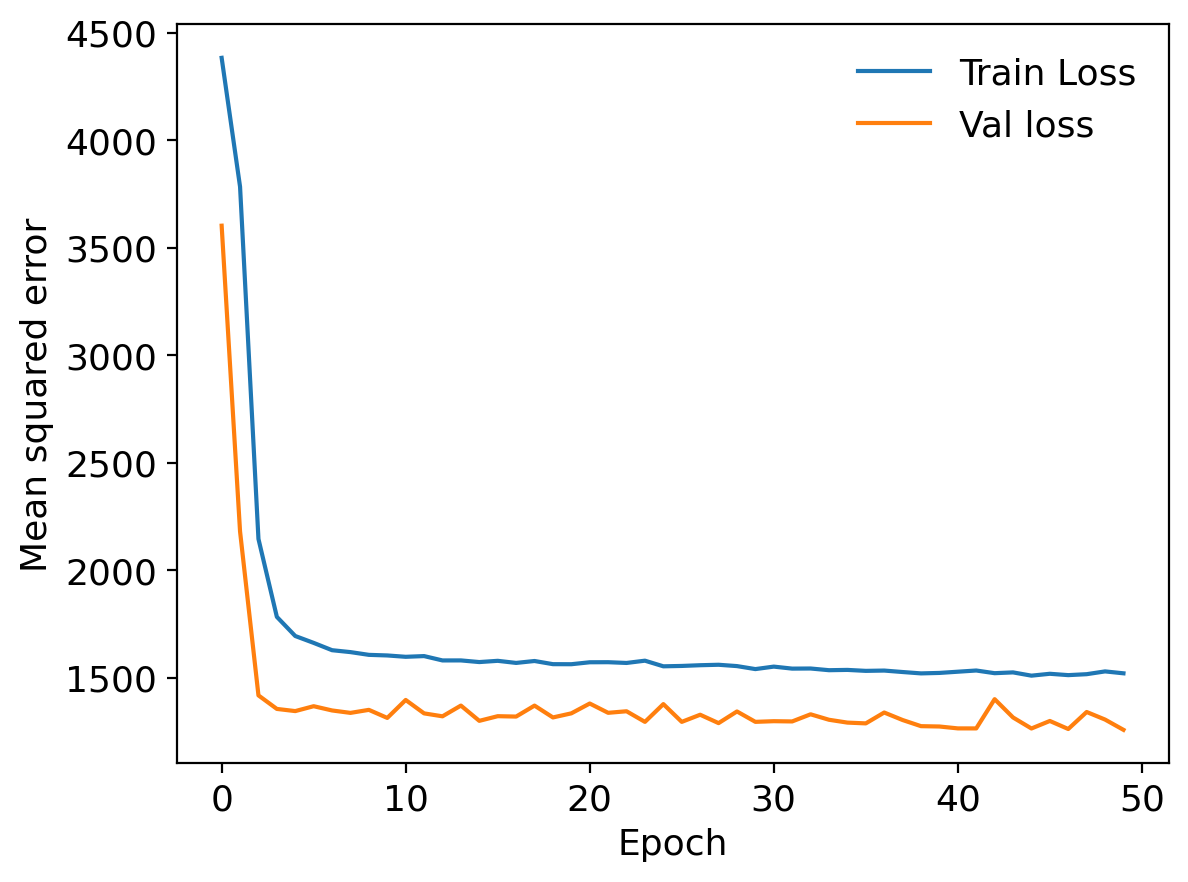

In [8]:
plot_history(history)

In [9]:
y_test_pre = model.predict(test_data)

9/9 [==============================] - 1s 75ms/step


In [10]:
rmes=np.sqrt(np.mean((y_test_pre-test_label)**2))
rmes

29.710234